In [61]:
!apt-get install unrar


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [62]:
import torch
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0))


PyTorch: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4


In [63]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from torchvision import datasets, transforms, models
from tqdm import tqdm

In [64]:
epoch=100
# Dataset'in ana klasör yolu
dataset_path = "Corn"
Model_Name="Resnet-18"


# Eğitilmiş modellerin kaydedileceği klasör yolu
model_save_path = f"Egitilen_Modeller/{dataset_path}"
os.makedirs(model_save_path, exist_ok=True)
Result=f"Resut/{dataset_path}/{Model_Name}"
os.makedirs(Result, exist_ok=True)



In [65]:
dataset_path = "/content/dataset"   # ← THIS is the fix

transform_visualization = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

visualization_dataset = datasets.ImageFolder(
    dataset_path,
    transform=transform_visualization
)

class_names = visualization_dataset.classes

transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [66]:
# Toplam görüntü sayısını yazdır
print(f"Toplam {len(visualization_dataset)} adet görüntü var.")

Toplam 6308 adet görüntü var.


In [67]:
# Her sınıf için örnek görsellerin görselleştirilmesi
class_names = visualization_dataset.classes  # Sınıf isimlerini alıyoruz
print(f"{len(class_names)} Tane Sınıf var. \n Sınıf İsimleri : {class_names}")

4 Tane Sınıf var. 
 Sınıf İsimleri : ['Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite']


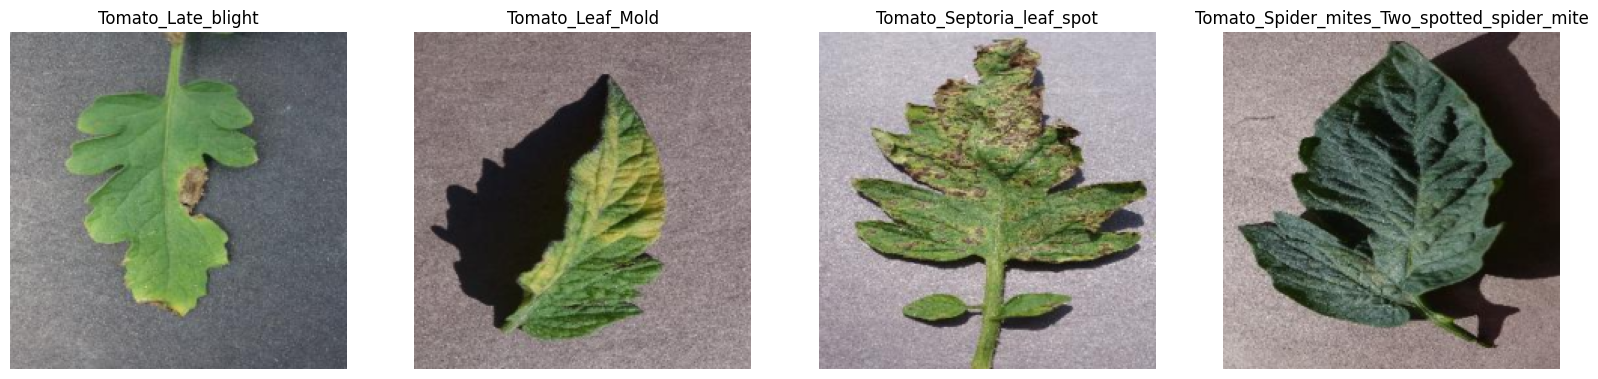

In [68]:
fig, axes = plt.subplots(1, len(class_names), figsize=(20, 15))  # Sınıf sayısına göre alt grafik oluşturuyoruz

for i, class_name in enumerate(class_names):
    class_idx = visualization_dataset.class_to_idx[class_name]  # Sınıfın index'ini alıyoruz
    class_subset = [idx for idx, (_, target) in enumerate(
        visualization_dataset) if target == class_idx]  # O sınıfa ait örneklerin indekslerini alıyoruz
    sample_idx = np.random.choice(class_subset, 1)[0]  # Rastgele bir örnek seçiyoruz
    img, label = visualization_dataset[sample_idx]  # Görseli ve etiketini alıyoruz
    axes[i].imshow(img.permute(1, 2, 0))  # Tensörü görselleştirmeye dönüştürüyoruz
    axes[i].set_title(class_name)  # Görselin başlığı sınıf ismi
    axes[i].axis('off')  # Ekseni gizliyoruz


In [69]:
plt.tight_layout()
plt.show()
full_dataset = datasets.ImageFolder(dataset_path, transform=transform)
train_ratio, val_ratio = 0.7, 0.15
train_size = int(len(full_dataset) * train_ratio)
val_size = int(len(full_dataset) * val_ratio)
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size])

<Figure size 640x480 with 0 Axes>

In [70]:
# Ayrıntıları yazdırma
print(f"Toplam veri kümesi: {len(full_dataset)} görüntü")
print(f"Eğitim seti: {train_size} görüntü (%{train_ratio*100:.1f})")
print(f"Doğrulama seti: {val_size} görüntü (%{val_ratio*100:.1f})")
print(f"Test seti: {test_size} görüntü (%{(1 - train_ratio - val_ratio)*100:.1f})")

Toplam veri kümesi: 6308 görüntü
Eğitim seti: 4415 görüntü (%70.0)
Doğrulama seti: 946 görüntü (%15.0)
Test seti: 947 görüntü (%15.0)


In [71]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [73]:
# Cihaz bilgisini yazdırma
if device.type == "cuda":
    print(f"Kod GPU üzerinde çalışıyor. (Cihaz: {torch.cuda.get_device_name(0)})")
else:
    print("Kod CPU üzerinde çalışıyor.")

Kod GPU üzerinde çalışıyor. (Cihaz: Tesla T4)


In [74]:
# Transfer learning için önceden eğitilmiş DenseNet121 modelini yükleme
model = models.resnet18(pretrained=True)


num_classes = len(full_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [75]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Eğitim ve doğrulama döngüsü
num_epochs = epoch
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
patience = 15
best_val_loss = float('inf')
patience_counter = 0

log_file =f"Transfer-Learning-{Model_Name}_Epoch_LOG.txt"
with open(log_file, "w") as file:
    file.write("Epoch\tTrain Loss\tVal Loss\tTrain Acc\tVal Acc\tLR\n")


for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    model.train()
    train_loss, train_correct = 0, 0
    for inputs, targets in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == targets).sum().item()
    train_acc = train_correct / len(train_loader.dataset)

    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc=f"Validating Epoch {epoch + 1}"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == targets).sum().item()
    val_acc = val_correct / len(val_loader.dataset)

    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, LR: {current_lr:.9f}")
    with open(log_file, "a") as file:
        file.write(f"{epoch+1}\t{train_loss/len(train_loader):.4f}\t{val_loss/len(val_loader):.4f}\t"
                   f"{train_acc:.4f}\t{val_acc:.4f}\t{current_lr:.9f}\n")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0 #os.path.join(model_save_path, f"Best_{Model_Name}.pth"
        torch.save(model.state_dict(), os.path.join(model_save_path, f"Best_{Model_Name}.pth"))
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping activated. No improvement in validation loss.")
            break


Epoch 1/100


Validating Epoch 1: 100%|██████████| 30/30 [00:09<00:00,  3.28it/s]


Epoch 1/100: Train Loss: 117.8776, Val Loss: 19.7241, Train Acc: 0.6766, Val Acc: 0.7706, LR: 0.001000000

Epoch 2/100


Validating Epoch 2: 100%|██████████| 30/30 [00:09<00:00,  3.23it/s]


Epoch 2/100: Train Loss: 77.0985, Val Loss: 13.6423, Train Acc: 0.8111, Val Acc: 0.8594, LR: 0.001000000

Epoch 3/100


Validating Epoch 3: 100%|██████████| 30/30 [00:08<00:00,  3.48it/s]


Epoch 3/100: Train Loss: 66.3315, Val Loss: 13.2668, Train Acc: 0.8317, Val Acc: 0.8457, LR: 0.001000000

Epoch 4/100


Validating Epoch 4: 100%|██████████| 30/30 [00:09<00:00,  3.26it/s]


Epoch 4/100: Train Loss: 58.4980, Val Loss: 12.1260, Train Acc: 0.8544, Val Acc: 0.8689, LR: 0.001000000

Epoch 5/100


Validating Epoch 5: 100%|██████████| 30/30 [00:09<00:00,  3.26it/s]


Epoch 5/100: Train Loss: 58.1626, Val Loss: 11.7415, Train Acc: 0.8460, Val Acc: 0.8615, LR: 0.001000000

Epoch 6/100


Validating Epoch 6: 100%|██████████| 30/30 [00:09<00:00,  3.27it/s]


Epoch 6/100: Train Loss: 55.7839, Val Loss: 11.7981, Train Acc: 0.8519, Val Acc: 0.8668, LR: 0.001000000

Epoch 7/100


Validating Epoch 7: 100%|██████████| 30/30 [00:09<00:00,  3.25it/s]


Epoch 7/100: Train Loss: 53.3914, Val Loss: 10.2301, Train Acc: 0.8602, Val Acc: 0.8837, LR: 0.001000000

Epoch 8/100


Validating Epoch 8: 100%|██████████| 30/30 [00:08<00:00,  3.43it/s]


Epoch 8/100: Train Loss: 51.3356, Val Loss: 10.5563, Train Acc: 0.8666, Val Acc: 0.8700, LR: 0.001000000

Epoch 9/100


Validating Epoch 9: 100%|██████████| 30/30 [00:09<00:00,  3.25it/s]


Epoch 9/100: Train Loss: 50.9546, Val Loss: 11.6357, Train Acc: 0.8664, Val Acc: 0.8499, LR: 0.001000000

Epoch 10/100


Validating Epoch 10: 100%|██████████| 30/30 [00:09<00:00,  3.24it/s]


Epoch 10/100: Train Loss: 51.2517, Val Loss: 9.9800, Train Acc: 0.8616, Val Acc: 0.8774, LR: 0.001000000

Epoch 11/100


Validating Epoch 11: 100%|██████████| 30/30 [00:09<00:00,  3.22it/s]


Epoch 11/100: Train Loss: 48.6335, Val Loss: 9.5057, Train Acc: 0.8741, Val Acc: 0.8837, LR: 0.001000000

Epoch 12/100


Validating Epoch 12: 100%|██████████| 30/30 [00:08<00:00,  3.49it/s]


Epoch 12/100: Train Loss: 48.9657, Val Loss: 9.6906, Train Acc: 0.8700, Val Acc: 0.8943, LR: 0.001000000

Epoch 13/100


Validating Epoch 13: 100%|██████████| 30/30 [00:09<00:00,  3.29it/s]


Epoch 13/100: Train Loss: 48.2715, Val Loss: 9.4327, Train Acc: 0.8691, Val Acc: 0.8869, LR: 0.001000000

Epoch 14/100


Validating Epoch 14: 100%|██████████| 30/30 [00:09<00:00,  3.19it/s]


Epoch 14/100: Train Loss: 50.1133, Val Loss: 11.4468, Train Acc: 0.8657, Val Acc: 0.8562, LR: 0.001000000

Epoch 15/100


Validating Epoch 15: 100%|██████████| 30/30 [00:09<00:00,  3.22it/s]


Epoch 15/100: Train Loss: 49.4473, Val Loss: 9.7039, Train Acc: 0.8700, Val Acc: 0.8816, LR: 0.001000000

Epoch 16/100


Validating Epoch 16: 100%|██████████| 30/30 [00:08<00:00,  3.39it/s]


Epoch 16/100: Train Loss: 48.8814, Val Loss: 8.9981, Train Acc: 0.8741, Val Acc: 0.8805, LR: 0.001000000

Epoch 17/100


Validating Epoch 17: 100%|██████████| 30/30 [00:08<00:00,  3.38it/s]


Epoch 17/100: Train Loss: 48.8065, Val Loss: 9.9600, Train Acc: 0.8766, Val Acc: 0.8848, LR: 0.001000000

Epoch 18/100


Validating Epoch 18: 100%|██████████| 30/30 [00:09<00:00,  3.29it/s]


Epoch 18/100: Train Loss: 49.1582, Val Loss: 10.2016, Train Acc: 0.8711, Val Acc: 0.8636, LR: 0.001000000

Epoch 19/100


Validating Epoch 19: 100%|██████████| 30/30 [00:09<00:00,  3.23it/s]


Epoch 19/100: Train Loss: 47.6977, Val Loss: 9.2131, Train Acc: 0.8727, Val Acc: 0.8816, LR: 0.001000000

Epoch 20/100


Validating Epoch 20: 100%|██████████| 30/30 [00:09<00:00,  3.23it/s]


Epoch 20/100: Train Loss: 46.7744, Val Loss: 10.2483, Train Acc: 0.8743, Val Acc: 0.8901, LR: 0.001000000

Epoch 21/100


Validating Epoch 21: 100%|██████████| 30/30 [00:08<00:00,  3.49it/s]


Epoch 21/100: Train Loss: 45.6446, Val Loss: 9.2226, Train Acc: 0.8818, Val Acc: 0.8901, LR: 0.001000000

Epoch 22/100


Validating Epoch 22: 100%|██████████| 30/30 [00:09<00:00,  3.18it/s]


Epoch 22/100: Train Loss: 48.8020, Val Loss: 9.6407, Train Acc: 0.8716, Val Acc: 0.8901, LR: 0.000100000

Epoch 23/100


Validating Epoch 23: 100%|██████████| 30/30 [00:09<00:00,  3.22it/s]


Epoch 23/100: Train Loss: 44.6870, Val Loss: 9.4219, Train Acc: 0.8804, Val Acc: 0.8964, LR: 0.000100000

Epoch 24/100


Validating Epoch 24: 100%|██████████| 30/30 [00:09<00:00,  3.23it/s]


Epoch 24/100: Train Loss: 42.3691, Val Loss: 9.2658, Train Acc: 0.8874, Val Acc: 0.8911, LR: 0.000100000

Epoch 25/100


Validating Epoch 25: 100%|██████████| 30/30 [00:08<00:00,  3.53it/s]


Epoch 25/100: Train Loss: 45.2198, Val Loss: 8.4155, Train Acc: 0.8793, Val Acc: 0.8943, LR: 0.000100000

Epoch 26/100


Validating Epoch 26: 100%|██████████| 30/30 [00:09<00:00,  3.28it/s]


Epoch 26/100: Train Loss: 42.6778, Val Loss: 9.1856, Train Acc: 0.8813, Val Acc: 0.8890, LR: 0.000100000

Epoch 27/100


Validating Epoch 27: 100%|██████████| 30/30 [00:09<00:00,  3.18it/s]


Epoch 27/100: Train Loss: 43.2928, Val Loss: 9.1979, Train Acc: 0.8838, Val Acc: 0.8890, LR: 0.000100000

Epoch 28/100


Validating Epoch 28: 100%|██████████| 30/30 [00:09<00:00,  3.18it/s]


Epoch 28/100: Train Loss: 42.6404, Val Loss: 8.4480, Train Acc: 0.8911, Val Acc: 0.8901, LR: 0.000100000

Epoch 29/100


Validating Epoch 29: 100%|██████████| 30/30 [00:08<00:00,  3.35it/s]


Epoch 29/100: Train Loss: 44.2104, Val Loss: 9.6683, Train Acc: 0.8815, Val Acc: 0.8890, LR: 0.000100000

Epoch 30/100


Validating Epoch 30: 100%|██████████| 30/30 [00:09<00:00,  3.22it/s]


Epoch 30/100: Train Loss: 44.6600, Val Loss: 9.0465, Train Acc: 0.8813, Val Acc: 0.8932, LR: 0.000100000

Epoch 31/100


Validating Epoch 31: 100%|██████████| 30/30 [00:09<00:00,  3.23it/s]


Epoch 31/100: Train Loss: 44.4812, Val Loss: 8.6662, Train Acc: 0.8811, Val Acc: 0.8837, LR: 0.000010000

Epoch 32/100


Validating Epoch 32: 100%|██████████| 30/30 [00:09<00:00,  3.18it/s]


Epoch 32/100: Train Loss: 42.9705, Val Loss: 8.4447, Train Acc: 0.8852, Val Acc: 0.8953, LR: 0.000010000

Epoch 33/100


Validating Epoch 33: 100%|██████████| 30/30 [00:09<00:00,  3.27it/s]


Epoch 33/100: Train Loss: 43.8322, Val Loss: 8.6208, Train Acc: 0.8788, Val Acc: 0.8869, LR: 0.000010000

Epoch 34/100


Validating Epoch 34: 100%|██████████| 30/30 [00:09<00:00,  3.22it/s]


Epoch 34/100: Train Loss: 41.5739, Val Loss: 7.5202, Train Acc: 0.8947, Val Acc: 0.9091, LR: 0.000010000

Epoch 35/100


Validating Epoch 35: 100%|██████████| 30/30 [00:09<00:00,  3.24it/s]


Epoch 35/100: Train Loss: 44.8603, Val Loss: 7.9961, Train Acc: 0.8856, Val Acc: 0.8964, LR: 0.000010000

Epoch 36/100


Validating Epoch 36: 100%|██████████| 30/30 [00:08<00:00,  3.38it/s]


Epoch 36/100: Train Loss: 42.9569, Val Loss: 9.5902, Train Acc: 0.8890, Val Acc: 0.8858, LR: 0.000010000

Epoch 37/100


Validating Epoch 37: 100%|██████████| 30/30 [00:08<00:00,  3.38it/s]


Epoch 37/100: Train Loss: 43.9494, Val Loss: 9.5815, Train Acc: 0.8867, Val Acc: 0.8922, LR: 0.000010000

Epoch 38/100


Validating Epoch 38: 100%|██████████| 30/30 [00:09<00:00,  3.18it/s]


Epoch 38/100: Train Loss: 42.5462, Val Loss: 8.4374, Train Acc: 0.8872, Val Acc: 0.9049, LR: 0.000010000

Epoch 39/100


Validating Epoch 39: 100%|██████████| 30/30 [00:09<00:00,  3.24it/s]


Epoch 39/100: Train Loss: 45.4726, Val Loss: 8.9490, Train Acc: 0.8777, Val Acc: 0.8922, LR: 0.000010000

Epoch 40/100


Validating Epoch 40: 100%|██████████| 30/30 [00:09<00:00,  3.24it/s]


Epoch 40/100: Train Loss: 44.7664, Val Loss: 8.8932, Train Acc: 0.8784, Val Acc: 0.8901, LR: 0.000001000

Epoch 41/100


Validating Epoch 41: 100%|██████████| 30/30 [00:08<00:00,  3.43it/s]


Epoch 41/100: Train Loss: 42.6427, Val Loss: 8.6768, Train Acc: 0.8890, Val Acc: 0.9038, LR: 0.000001000

Epoch 42/100


Validating Epoch 42: 100%|██████████| 30/30 [00:09<00:00,  3.17it/s]


Epoch 42/100: Train Loss: 45.7055, Val Loss: 8.9114, Train Acc: 0.8786, Val Acc: 0.8869, LR: 0.000001000

Epoch 43/100


Validating Epoch 43: 100%|██████████| 30/30 [00:09<00:00,  3.18it/s]


Epoch 43/100: Train Loss: 44.7453, Val Loss: 9.1433, Train Acc: 0.8872, Val Acc: 0.8922, LR: 0.000001000

Epoch 44/100


Validating Epoch 44: 100%|██████████| 30/30 [00:09<00:00,  3.24it/s]


Epoch 44/100: Train Loss: 44.6880, Val Loss: 8.7427, Train Acc: 0.8854, Val Acc: 0.8890, LR: 0.000001000

Epoch 45/100


Validating Epoch 45: 100%|██████████| 30/30 [00:09<00:00,  3.12it/s]


Epoch 45/100: Train Loss: 44.8233, Val Loss: 9.1653, Train Acc: 0.8802, Val Acc: 0.8795, LR: 0.000001000

Epoch 46/100


Validating Epoch 46: 100%|██████████| 30/30 [00:09<00:00,  3.15it/s]


Epoch 46/100: Train Loss: 44.3484, Val Loss: 9.6228, Train Acc: 0.8809, Val Acc: 0.8827, LR: 0.000000100

Epoch 47/100


Validating Epoch 47: 100%|██████████| 30/30 [00:09<00:00,  3.26it/s]


Epoch 47/100: Train Loss: 44.4501, Val Loss: 7.8531, Train Acc: 0.8811, Val Acc: 0.9038, LR: 0.000000100

Epoch 48/100


Validating Epoch 48: 100%|██████████| 30/30 [00:08<00:00,  3.49it/s]


Epoch 48/100: Train Loss: 43.3836, Val Loss: 9.5755, Train Acc: 0.8793, Val Acc: 0.8858, LR: 0.000000100

Epoch 49/100


Validating Epoch 49: 100%|██████████| 30/30 [00:09<00:00,  3.24it/s]

Epoch 49/100: Train Loss: 43.1036, Val Loss: 9.3225, Train Acc: 0.8901, Val Acc: 0.8996, LR: 0.000000100
Early stopping activated. No improvement in validation loss.


In [76]:
# epochs = np.arange(1, num_epochs + 1)
epochs = np.arange(1, len(train_losses) + 1)
plt.figure(figsize=(20, 6))

# Kayıp grafiği
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Doğruluk grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

save_path = os.path.join(Result, f"training_metrics_{Model_Name}.png")

# Dosyaya kaydet
plt.tight_layout()
plt.savefig(save_path)  # Grafik dosyası olarak kaydeder
plt.close()  # Grafik penceresini kapatır

In [77]:
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

In [78]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Confusion matrix hesapla ve görselleştir
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=full_dataset.classes,
            yticklabels=full_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f"CM {Model_Name}")

save_path = os.path.join(Result, f"confusion_matrix_{Model_Name}.png")


# Dosyaya kaydet
plt.tight_layout()
plt.savefig(save_path)
plt.close()

In [79]:
# Accuracy, Precision, Recall, F1-Score hesapla
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')  # 'macro' tüm sınıfların ortalamasını alır
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Test Accuracy : {acc:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall   : {recall:.4f}")
print(f"Test F1-Score : {f1:.4f}")

# İsteğe bağlı olarak her sınıf için detaylı sınıflandırma raporu
report = classification_report(y_true, y_pred, target_names=full_dataset.classes)
print("\nClassification Report:\n", report)

# Raporu dosyaya yazmak istersen:
import os
report_path = os.path.join(Result, f"{Model_Name}_classification_report.txt")
with open(report_path, "w") as f:
    f.write(f"Test Accuracy : {acc:.4f}\n")
    f.write(f"Test Precision: {precision:.4f}\n")
    f.write(f"Test Recall   : {recall:.4f}\n")
    f.write(f"Test F1-Score : {f1:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(report)


Test Accuracy : 0.9039
Test Precision: 0.8968
Test Recall   : 0.8943
Test F1-Score : 0.8955

Classification Report:
                                              precision    recall  f1-score   support

                         Tomato_Late_blight       0.91      0.91      0.91       289
                           Tomato_Leaf_Mold       0.84      0.82      0.83       153
                  Tomato_Septoria_leaf_spot       0.90      0.89      0.90       240
Tomato_Spider_mites_Two_spotted_spider_mite       0.93      0.96      0.94       265

                                   accuracy                           0.90       947
                                  macro avg       0.90      0.89      0.90       947
                               weighted avg       0.90      0.90      0.90       947

